In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import keras
import cv2
import pickle
import sklearn
import random

from PIL import Image
from sklearn.metrics import auc, f1_score, roc_curve, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn import metrics
from google.colab import files
from keras.preprocessing import image
from keras.layers.serialization import activation
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import *
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.models import load_model
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

#**Data directory**

In [2]:
base_dir = '/content/drive/MyDrive/TIFF-PETonlyWholeDataset'

training_set_dir = os.path.join(base_dir, 'trainingSet')
test_set_dir = os.path.join(base_dir, 'testSet')

train_lungCancer_dir = os.path.join(training_set_dir, 'lungCancer')
train_normal_dir = os.path.join(training_set_dir, 'normal')
test_lungCancer_dir = os.path.join(test_set_dir, 'lungCancer')
test_normal_dir = os.path.join(test_set_dir, 'normal')

In [3]:
print('total training lungCancer images:', len(os.listdir(train_lungCancer_dir)))
print('total training normal images:', len(os.listdir(train_normal_dir)))

total training lungCancer images: 811
total training normal images: 811


#**Checking patient overlap**

In [4]:
def check_data_leakage(directory1, directory2):
    filenames_dir1 = set(os.listdir(directory1))
    filenames_dir2 = set(os.listdir(directory2))

    common_filenames = filenames_dir1.intersection(filenames_dir2)

    if len(common_filenames) > 0:
        print("Data leakage detected!")
        print("Common image filenames between the directories:", common_filenames)
    else:
        print("No data leakage detected.")

In [5]:
check_data_leakage(train_lungCancer_dir, test_lungCancer_dir)
check_data_leakage(train_normal_dir, test_normal_dir)
check_data_leakage(train_lungCancer_dir, test_normal_dir)
check_data_leakage(train_normal_dir, test_lungCancer_dir)

No data leakage detected.
No data leakage detected.
No data leakage detected.
No data leakage detected.


#**Data visualization**

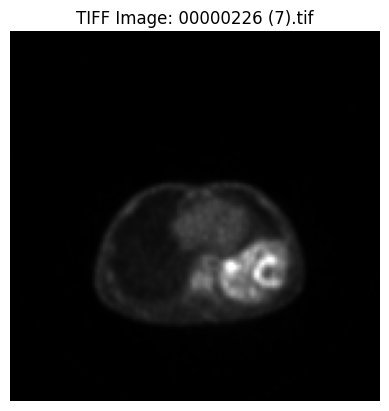

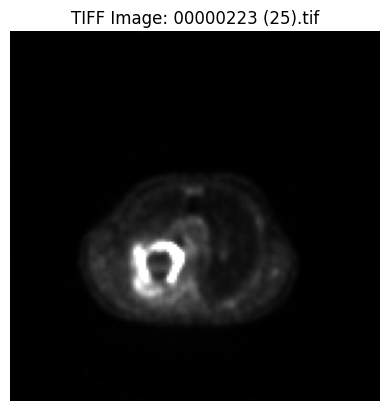

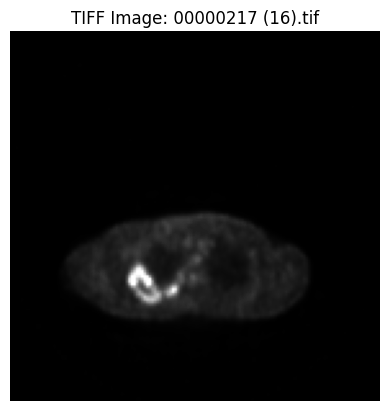

In [6]:
def display_random_tif_images(directory, num_images=3):
    filenames = os.listdir(directory)
    random_images = random.sample(filenames, num_images)

    for filename in random_images:
        image_path = os.path.join(directory, filename)
        img = Image.open(image_path)
        img_array = np.array(img)

        plt.imshow(img_array, cmap='gray')
        plt.title(f"TIFF Image: {filename}")
        plt.axis('off')
        plt.show()

display_random_tif_images(test_lungCancer_dir, num_images=3)

#**Data generation**

In [ ]:
BATCH_SIZE= 80
image_height, image_width = 144, 144
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  rotation_range= 5,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.05,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        training_set_dir,
        target_size=(image_height, image_width),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle = True)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
        test_set_dir,
        target_size=(image_height, image_width),
        batch_size=10,
        class_mode='binary')

#**Defining model**

In [9]:
pre_trained_model = VGG19(include_top=False,
                                        weights= 'imagenet',
                                        input_shape = (image_height, image_width, 3))

for layer in pre_trained_model.layers:
  layer.trainable = True

80134624/80134624 [==============================] - 0s 0us/step


In [10]:
pre_trained_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 144, 144, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 144, 144, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 144, 144, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 72, 72, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 72, 72, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 72, 72, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 36, 36, 128)       0     

In [11]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
# x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(1)(x)
x = layers.Activation(tf.nn.sigmoid)(x)

model = Model(pre_trained_model.input, x)

last layer output shape:  (None, 4, 4, 512)


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 144, 144, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 144, 144, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 144, 144, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 72, 72, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 72, 72, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 72, 72, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 36, 36, 128)       0     

In [13]:
savingPath = os.makedirs('/content/sample_data/temporaryWeights')
checkpoint_path = '/content/sample_data/temporaryWeights'
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, verbose= 1)

/content/sample_data/temporaryWeights


In [15]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate= 0.001), loss= 'binary_crossentropy',
              metrics= [tf.keras.metrics.BinaryAccuracy(name="Binary_accuracy"),
                        tf.keras.metrics.Precision(name='Precision'),
                        tf.keras.metrics.Recall(name='Recall'),
                        tf.keras.metrics.TruePositives(name='TP'),
                        tf.keras.metrics.TrueNegatives(name='TN'),
                        tf.keras.metrics.FalseNegatives(name='FN'),
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.AUC(name='AUC')])

In [16]:
history = model.fit(
            train_generator,
            validation_data = test_generator,
            epochs = 30,
            verbose = 1,
            callbacks = [cp_callback])

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.6889 - Binary_accuracy: 0.5302 - Precision: 0.7475 - Recall: 0.0912 - TP: 74.0000 - TN: 786.0000 - FN: 737.0000 - FP: 25.0000 - AUC: 0.5973
Epoch 1: val_loss improved from inf to 0.68524, saving model to /content/sample_data/temporaryWeights
21/21 [==============================] - 131s 6s/step - loss: 0.6889 - Binary_accuracy: 0.5302 - Precision: 0.7475 - Recall: 0.0912 - TP: 74.0000 - TN: 786.0000 - FN: 737.0000 - FP: 25.0000 - AUC: 0.5973 - val_loss: 0.6852 - val_Binary_accuracy: 0.5816 - val_Precision: 0.6731 - val_Recall: 0.3500 - val_TP: 70.0000 - val_TN: 158.0000 - val_FN: 130.0000 - val_FP: 34.0000 - val_AUC: 0.6617
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.6835 - Binary_accuracy: 0.5740 - Precision: 0.6676 - Recall: 0.2947 - TP: 239.0000 - TN: 692.0000 - FN: 572.0000 - FP: 119.0000 - AUC: 0.6192
Epoch 2: val_loss improved from 0.68524 to 0.68415, saving model to /content/sample_da

##**Plotting Loss and Accuracy**

In [ ]:
plt.plot(history.history['Binary_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_Binary_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss and Test Loss')
plt.show()